In [ ]:
# For any notebook
# !git clone https://github.com/nMaax/mldl_project_skeleton
# !pip install -r mldl_project_skeleton/requirements.txt
# %cd mldl_project_skeleton

In [2]:
from utils import download_and_unzip

In [ ]:
download_and_unzip(verbose=True)

Dataset already exists, skipping download.


In [ ]:
import yaml

# Load the configuration from the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Input images
input_image_size = tuple(config['data_info']['image_size'])
input_image_channels = config['data_info']['image_channels']
num_classes = config['data_info']['num_classes']

# Training
epochs = config['train']['epochs']
batch_size_train = config['train']['batch_size']
learning_rate = config['train']['learning_rate']
num_train_workers = config['train']['num_train_workers']

# Eval
batch_size_val = config['val']['batch_size']

# Device
device = config['device']

In [5]:
import torch

# Check for GPU availability and move model and data
if device == "cpu":
    device = torch.device("cpu")
    print("Training on CPU.")
elif device == "cuda" and torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available. Training on:", device)
else:
    device = torch.device("cpu")
    print("GPU not available. Training on CPU.")

GPU is available. Training on: cuda


In [6]:
import torchvision.transforms as transforms
from utils import get_dataloaders
transform = transforms.Compose([
        transforms.Resize(input_image_size),  # Resize to fit the input dimensions of the network
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

train_loader, val_loader = get_dataloaders(transform=transform, batch_size_train=batch_size_train, batch_size_val=batch_size_val, num_train_workers=num_train_workers)
# Check that the number of classes in the input is the same as the one in the dataset
assert num_classes == len(train_loader.dataset.classes), f"Number of classes in the config ({num_classes}) does not match the number of classes in the dataset ({len(train_loader.dataset.classes)})"

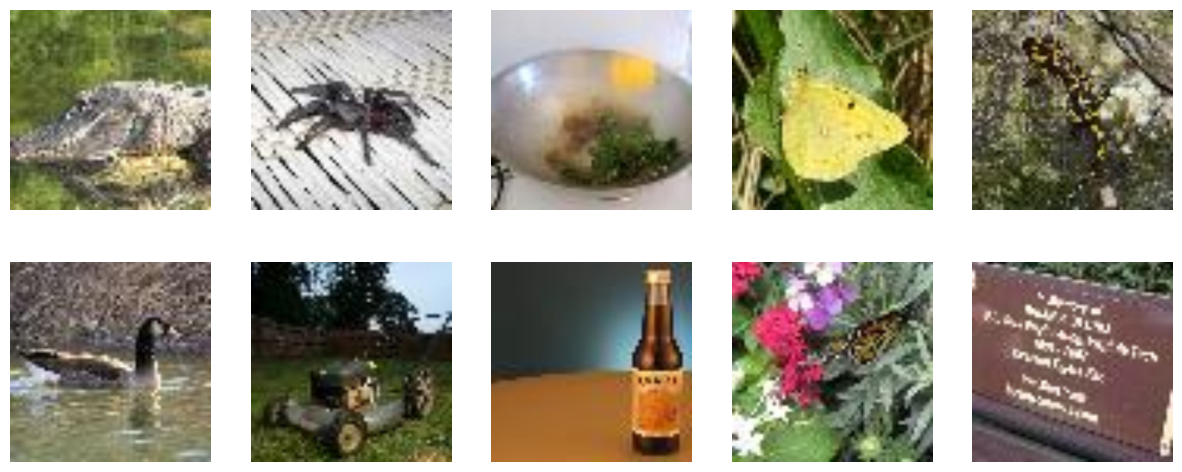

In [7]:
from utils import visualize_samples
visualize_samples(train_loader)

In [8]:
from models import CustomNet
model = CustomNet(input_shape=(input_image_channels, *input_image_size), num_classes=num_classes).to(device)

Input to the Fully Connected layer is of size: 18432


In [ ]:
import wandb
from torch import nn
from eval import validate
from train import train

# Start a new wandb run to track this script.
wandb_run = wandb.init(
    # Set the wandb entity where your project will be logged (generally your team name).
    #entity="my-awesome-team-name",
    # Set the wandb project where this run will be logged.
    project="my-awesome-project",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": learning_rate,
        "epochs": epochs,
    },
)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

best_acc = 0

# Run the training process for {epochs} epochs
for epoch in range(1, epochs + 1):
    print(f"Start epoch {epoch}")

    print("Training...")
    train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, verbose=False)
    print(f'Train Epoch: {epoch} Loss: {train_loss:.6f} Acc: {train_accuracy:.2f}%')

    # At the end of each training iteration, perform a validation step
    print("Validating...")
    val_loss, val_accuracy = validate(model, val_loader, criterion, verbose=True)
    print(f'Validation Loss: {val_loss:.6f} Acc: {val_accuracy:.2f}%')

    print(f"End poch {epoch} / {epochs} ({epoch/epochs*100:.2f}%)")

    # Best validation accuracy
    best_acc = max(best_acc, val_accuracy)

print(f'Best validation accuracy: {best_acc:.2f}%')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: carli-massimiliano01 (carli-massimiliano01-none) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Start epoch 1
Training...


KeyboardInterrupt: 

In [ ]:
wandb.finish()